# **Notebook 5: Sales Price Prediction**

## Objectives

* Train a ML pipeline using tuning with the best features to predict a property's sale price.

## Tasks

* Loading Data from cleaned data outputs
* Creating the ML Regressor Pipelines
* Split Train and Test sets
* Grid Search CV - Sklearn

## Additional Comments

* This notebook was informed and guided by the steps provided in the Customer Churn Walkthrough Porject.

* We intend to explore the data using the CRISP-DM Data methodology.


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
# os.chdir('workspace') 
current_dir = os.getcwd()
current_dir

'/workspace/Housing-Predictive-Analytics/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Housing-Predictive-Analytics'

# Import Packages

In [4]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

---

# Load House Price Records

Read the house_prices_records dataset csv file into a Pandas dataframe.

In [5]:
df = pd.read_csv(f"outputs/datasets/cleaned/clean_house_price_records.csv")
print(df.shape)
df.head()


(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854,3,3,706,2,150,548,2,2003,1710,2,8450,65,196,61,5,7,856,2003,2003,208500
1,1262,0,3,1,978,0,284,460,2,1976,1262,3,9600,80,0,0,8,6,1262,1976,1976,181500
2,920,866,3,2,486,2,434,608,2,2001,1786,2,11250,68,162,42,5,7,920,2001,2002,223500
3,961,0,0,3,216,0,540,642,3,1998,1717,2,9550,60,0,35,5,7,756,1915,1970,140000
4,1145,0,4,0,655,2,490,836,2,2000,2198,2,14260,84,350,84,5,8,1145,2000,2000,250000


---

# ML Regressor Pipeline

* Here we create the ML pipeline for Data Cleaning and Feature Engineering

In [6]:
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine import transformation as vt
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

selection_method = "cardinality"
corr_method = "spearman"

def PipelineOptimization(model):
    pipeline_base = Pipeline([

      ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                   variables=['BsmtExposure',
                                                              'BsmtFinType1',
                                                              'GarageFinish',
                                                              'KitchenQual'])),

      ("NumericLogTransform", vt.LogTransformer(variables=['1stFlrSF',
                                                           'LotArea',
                                                           'GrLivArea'])),
      ("NumericPowerTransform", vt.PowerTransformer(variables=['MasVnrArea'])),
      ("NumericYeoJohnsonTransform",
       vt.YeoJohnsonTransformer(variables=['OpenPorchSF'])),

      ("SmartCorrelatedSelection",
       SmartCorrelatedSelection(variables=None,
                                method=corr_method,
                                threshold=0.6,
                                selection_method=selection_method
                                )),
    
      ("feat_scaling", StandardScaler()),

      ("feat_selection",  SelectFromModel(model)),

      ("model", model),

    ])

    return pipeline_base

## Hyperparameter Optimisation

* Custom Class for hyperparameter Optimization

In [7]:
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## Split Train and Test datasets

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'], axis=1),
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


---

Model Evaluation 

* Train Set
R2 Score: 0.9786462363458367
Mean Absolute Error: 6709.541
Mean Squared Error: 131474272.676
Root Mean Squared Error: 11466.223


* Test Set
R2 Score: 0.8427476096500527
Mean Absolute Error: 17967.171
Mean Squared Error: 1085961414.238
Root Mean Squared Error: 32953.929




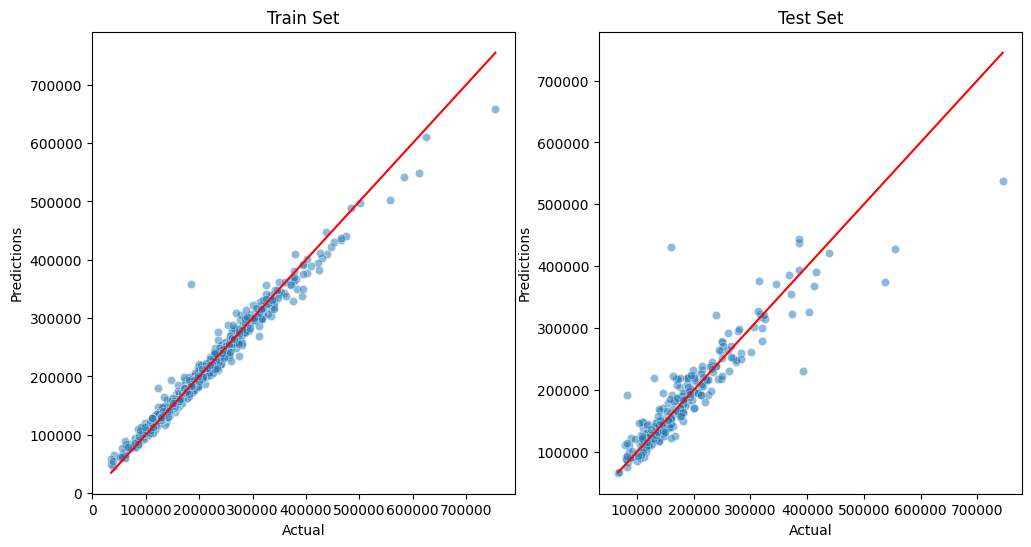

In [9]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
# df = pd.read_csv('your_dataset.csv')  # Replace with your dataset path

# Assuming df is your DataFrame with the cleaned data

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling the features
    ('regressor', RandomForestRegressor(random_state=0))  # Regressor model
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate the model
def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

# Run performance evaluation
regression_performance(X_train, y_train, X_test, y_test, pipeline)

# Run evaluation plots
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline)


# Regressor Model Analysis findings

* A Regressor model was chosen to predict sale price for a given property.

* Both feature selection and PCA produced close results and met business requirement 1. Despite by a small margin, feature 
selection performed better. Therefore, the best pipeline to use will be that of feature selection in this case. 

* Feature selection achieved an R2 Score: 0.97 on the train set and an R2 Score: 0.78 on the test set.

* The client requirement is for an R2 Score of 0.75\n"

# Refit pipeline with optimal determined features

## Rewrite Pipeline

In [10]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

      ("NumericLogTransform", vt.LogTransformer(variables=['1stFlrSF',
                                                           'GrLivArea'])),

      ("feat_scaling", StandardScaler()),

      ("model", model),

    ])

    return pipeline_base

---

Model Evaluation 

* Train Set
R2 Score: 0.9738362766339652
Mean Absolute Error: 7420.32
Mean Squared Error: 161089003.127
Root Mean Squared Error: 12692.084


* Test Set
R2 Score: 0.8499337575128889
Mean Absolute Error: 17758.819
Mean Squared Error: 1036334955.278
Root Mean Squared Error: 32192.157




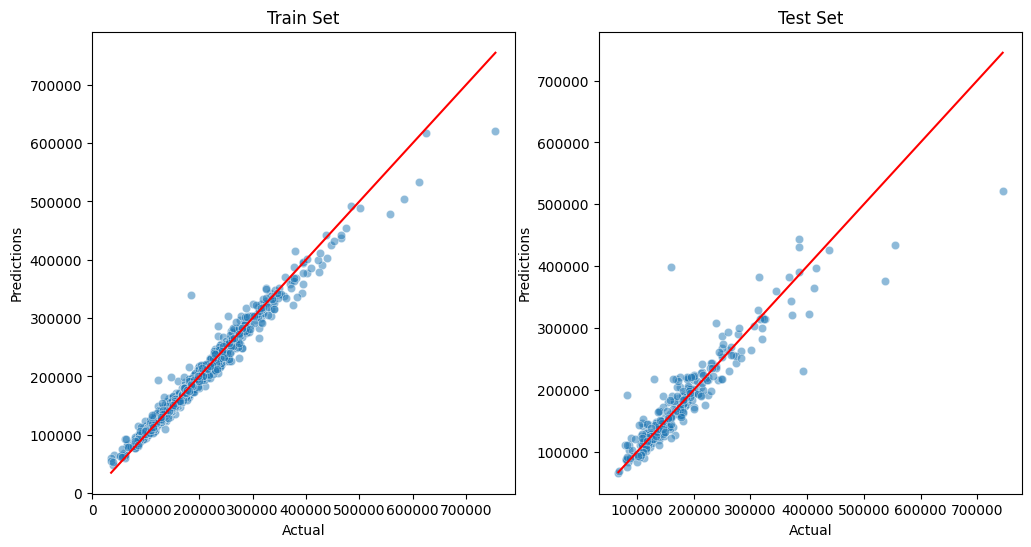

In [11]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib



# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling the features
    ('regressor', RandomForestRegressor(random_state=0))  # Regressor model
])

# Define hyperparameters for RandomForestRegressor to search
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__bootstrap': [True, False]
}

# Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_grid, n_iter=10, 
    cv=5, scoring='r2', n_jobs=-1, random_state=0
)

# Train the best model
random_search.fit(X_train, y_train)

# Save the best model
best_model = random_search.best_estimator_
joblib.dump(best_model, 'best_regressor_model.pkl')

# Save the cleaned dataset
df.to_csv('cleaned_housing_dataset.csv', index=False)

# Evaluate the best model
def regression_performance(X_train, y_train, X_test, y_test, model):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, model)
    print("* Test Set")
    regression_evaluation(X_test, y_test, model)

def regression_evaluation(X, y, model):
    prediction = model.predict(X)
    print('R2 Score:', r2_score(y, prediction))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, model, alpha_scatter=0.5):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

# Evaluate the performance of the best model
regression_performance(X_train, y_train, X_test, y_test, best_model)

# Plot the evaluation
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_model)


---

# Save datasets and models 

In [12]:
print(y_train.shape)
y_train.head()

(1168,)


618    314813
870    109500
92     163500
817    271000
302    205000
Name: SalePrice, dtype: int64

In [13]:
y_train.to_csv(f"y_train.csv", index=False)

## Test Set: Features and Target

In [14]:
print(X_test.shape)
X_test.head()

(292, 21)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
529,2515,0,4,3,1219,5,816,484,4,1975,2515,3,32668,69,0,0,3,6,2035,1957,1975
491,958,620,3,3,403,1,238,240,3,1941,1578,1,9490,79,0,0,7,6,806,1941,1950
459,979,224,3,3,185,3,524,352,3,1950,1203,2,7015,69,161,0,4,5,709,1950,1950
279,1156,866,4,3,392,1,768,505,0,1977,2022,3,10005,83,299,117,5,7,1160,1977,1977
655,525,0,3,3,0,6,525,264,3,1971,1092,3,1680,21,381,0,5,6,525,1971,1971


In [15]:
X_train.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
618,1828,0,0,0,48,7,1774,774,3,2007,1828,2,11694,90,452,108,5,9,1822,2007,2007
870,894,0,2,3,0,6,894,308,4,1962,894,3,6600,60,0,0,5,5,894,1962,1962
92,964,0,2,3,713,0,163,432,3,1921,964,3,13360,80,0,0,7,5,876,1921,2006
817,1689,0,3,3,1218,2,350,857,2,2002,1689,2,13265,69,148,59,5,8,1568,2002,2002
302,1541,0,3,3,0,6,1541,843,2,2001,1541,2,13704,118,150,81,5,7,1541,2001,2002


In [16]:
X_train.to_csv(f"X_train.csv", index=False)

In [17]:
X_test.to_csv(f"X_test.csv", index=False)

In [18]:
print(y_test.shape)
y_test.head()

(292,)


529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [19]:
y_test.to_csv(f"y_test.csv", index=False)

## Conclusion

The following files were generated:

* Train set
* Test set
* Modeling pipeline
* features importance plot

* A Regressor model was chosen to predict sale price for a given property suggesting that feature selection and PCA produced close results that meet the business requirements. However, with a small margin we found that feature selction had better performance and was therefore chosen as the best pipeline for our buiness case. The following results were produce to meet our targets:

* Feature selection achieved an R2 Score: 0.97 on the train set and an R2 Score: 0.78 on the test set.

* The client requirement is for an R2 Score of 0.75\n"

